# COVID-19 Spain. Analysis

## Simple data analysis and visualisation

Initial imports

In [432]:
%matplotlib inline
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict
sns.set_context("talk", font_scale=1.4)

We read the most updated version of the dataset. Data is obtained from **datadista** repository (https://github.com/datadista/datasets/tree/master/COVID%2019), who have gently provided a usable version (in CSV) of the official data (published in non-usable formats).

In [433]:
def read_covid_csv(data_url: str) -> pd.DataFrame:
    df = pd.read_csv(data_url, index_col=0).set_index("CCAA").transpose()
    dates = pd.to_datetime(df.index, format="%d/%m/%Y")
    df.index = dates
    return df.sort_index()

In [434]:
url_prefix = "https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019"
cases_url = f"{url_prefix}/ccaa_covid19_casos.csv"
recovered_url = f"{url_prefix}/ccaa_covid19_altas.csv"
deceased_url = f"{url_prefix}/ccaa_covid19_fallecidos.csv"

dfs = {}
dfs["cases"] = read_covid_csv(cases_url)
dfs["recovered"] = read_covid_csv(recovered_url)
dfs["deceased"] = read_covid_csv(deceased_url)

Growth charts, total and by region

In [435]:
def single_plot(dfs: Dict[str, pd.DataFrame], key_to_plot=str, logscale=False,
                title="COVID-19 situation in Spain", plot_last=False, percent=False):
    fig, ax = plt.subplots(figsize=(16, 9))
    for key, label, color in zip(["cases", "recovered", "deceased"],
                                 ["Positives", "Recovered", "Deceased"],
                                 ["navy", "orange", "green"]):
        # plot series
        dfs[key].plot(y=key_to_plot, ax=ax, label=label, logy=logscale, lw=3,
                     color=color)
        # annotate with last dot, if required
        if plot_last:
            last_row = dfs[key].tail(1)
            last_y = last_row[key_to_plot].values[0]
            last_row.plot(y=key_to_plot, color=color, ax=ax, marker="o", 
                          legend=False)
            last_point_legend = f"{last_y:.1f}%" if percent else f"{last_y:,}"
            ax.text(last_row.index[0] + pd.Timedelta("24h"),
                    last_y, last_point_legend,
                    ha='center', va="center", fontsize=12)

    # adjust axis, add two extra days to give room for the label plots
    plt.xlim(dfs["cases"].index[0], dfs["cases"].index[-1] + pd.Timedelta("48h"))
            
    today = dfs["cases"].index[-1].date()
    fig.patch.set_facecolor('#E0E0E0')

    if logscale:
        plt.title(f"{title} ({key_to_plot}), as of {today} (log-scale)")
    else:
        plt.title(f"{title} ({key_to_plot}), as of {today}")
    plt.xlabel("Date")        

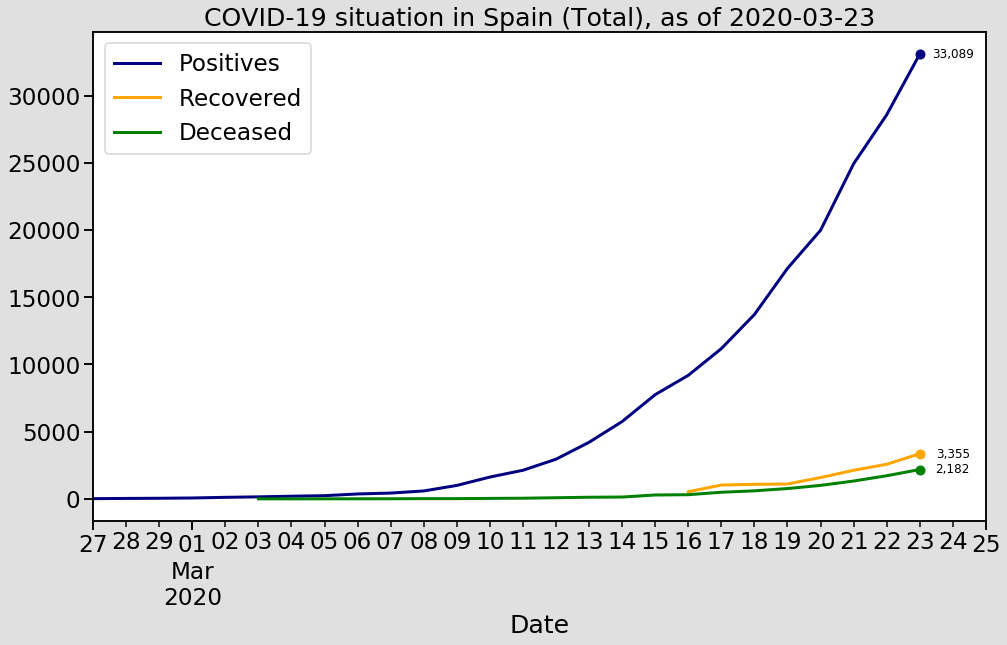

In [436]:
single_plot(dfs, key_to_plot="Total", plot_last=True)

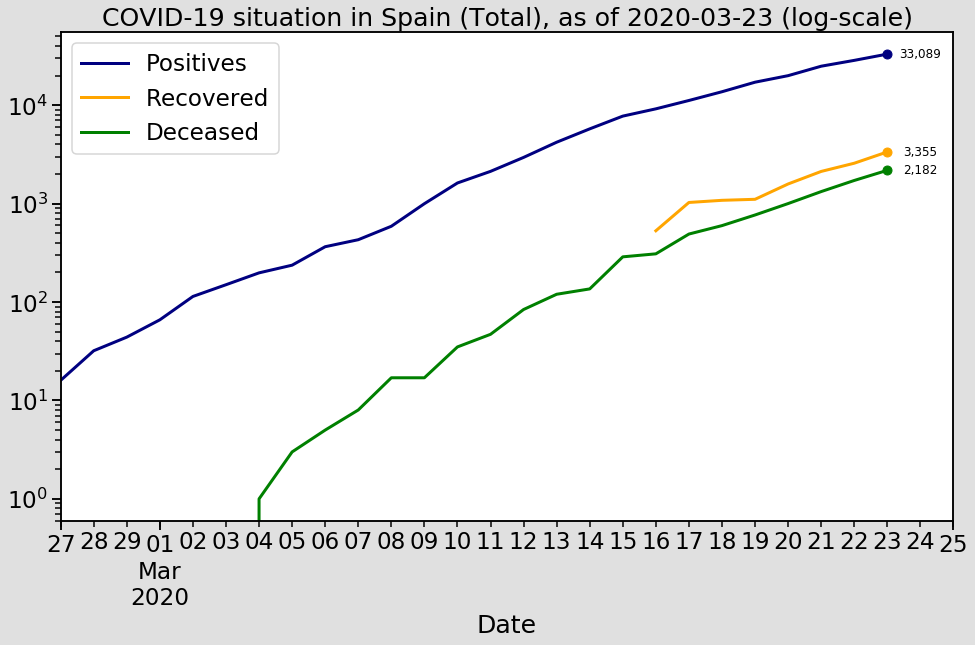

In [437]:
single_plot(dfs, key_to_plot="Total", logscale=True, plot_last=True)

In [438]:
def regional_plot(dfs: Dict[str, pd.DataFrame], logscale=False, title="Situation for"):
    regions = list(dfs["cases"].columns)
    ROWS, COLS = 5, 4
    row, col = 0, 0
    fig, axs = plt.subplots(ROWS, COLS)
    fig.patch.set_facecolor('#E0E0E0')
    fig.subplots_adjust(top=1)
    today = dfs["cases"].index[-1].date()
    fig.set_figheight(94)
    fig.set_figwidth(75)

    if logscale:
        plt.suptitle(f"Plots by region as of {today}, logarithmic scale", size=100, y=1.03)
    else:
        plt.suptitle(f"Plots by region as of {today}", size=100, y=1.03)


    for region in regions:
        axis_i = axs[row, col]
        dfs["cases"].plot(y=region, ax=axis_i,
                          label="Positives", logy=logscale, lw=3)
        dfs["recovered"].plot(y=region, ax=axis_i,
                              label="Recovered", logy=logscale, lw=3)
        dfs["deceased"].plot(y=region, ax=axis_i,
                             label="Deceased", logy=logscale, lw=3)
        if region != "Total":
            axis_i.set_title(f"{title} {region}")
        else:
            axis_i.set_title(f"Aggregated situation")
        
        col = (col + 1) % COLS
        if col == 0:
            row += 1
#     plt.tight_layout()
    plt.show()

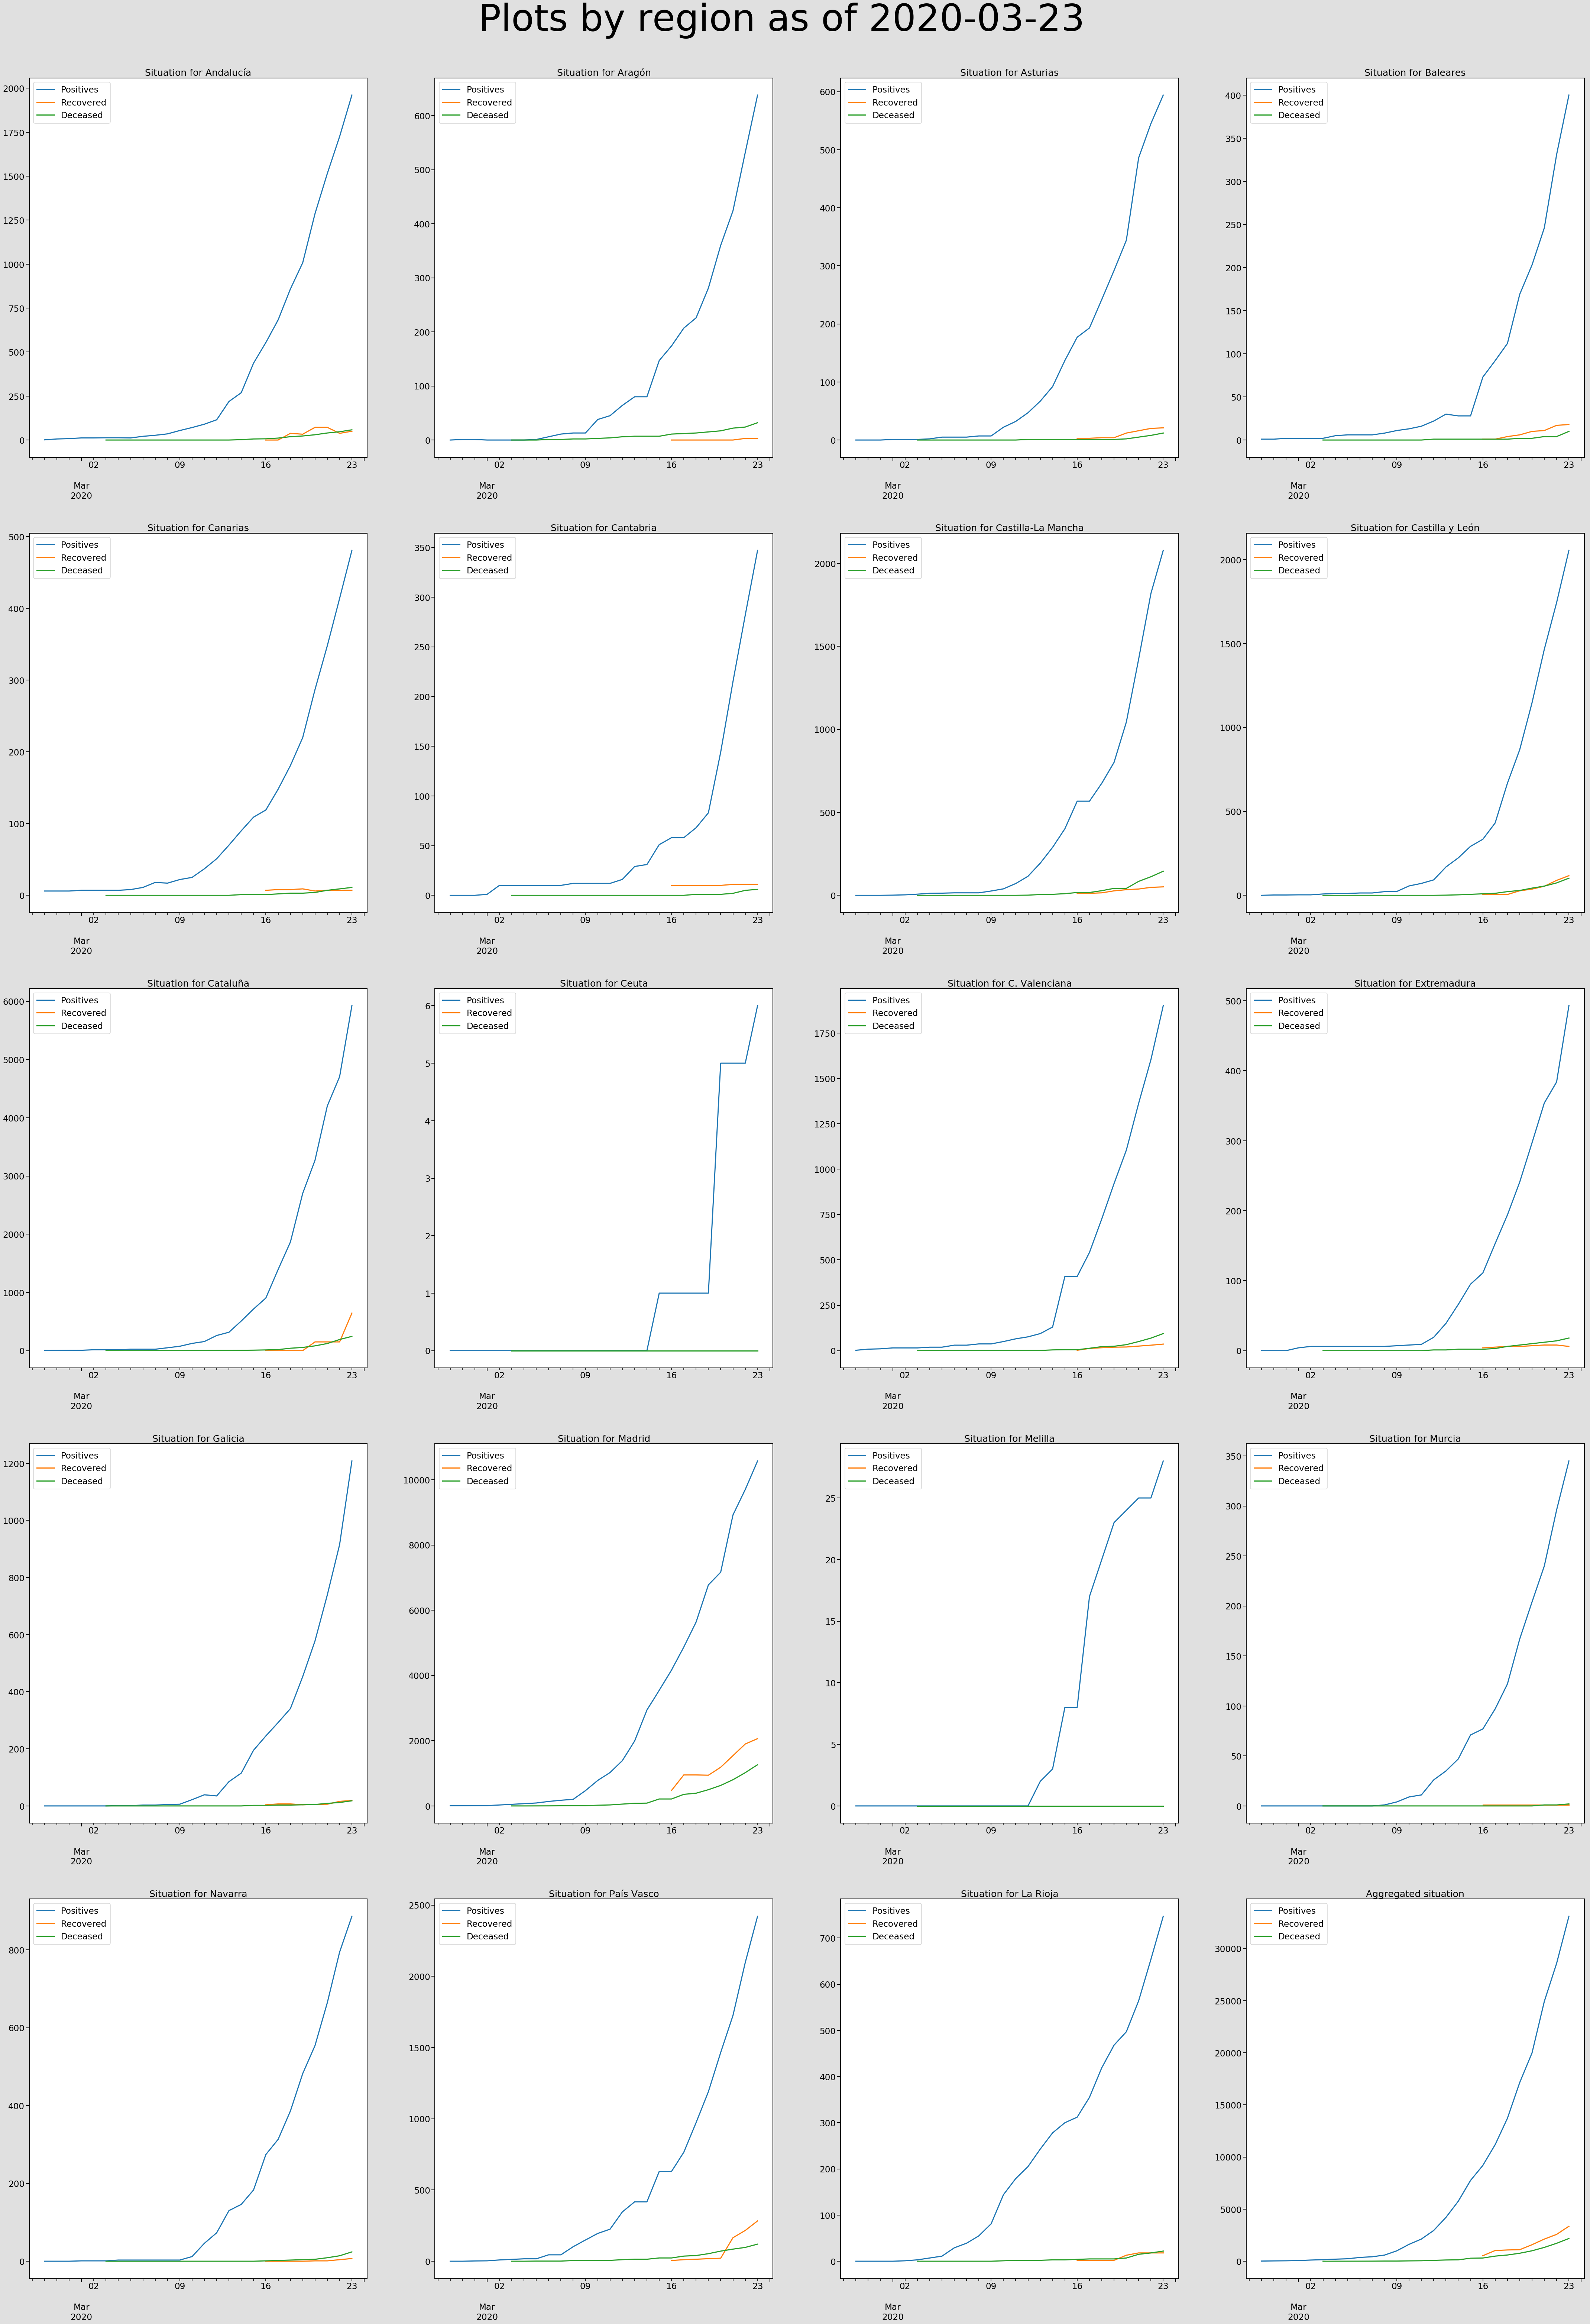

In [439]:
regional_plot(dfs, logscale=False)

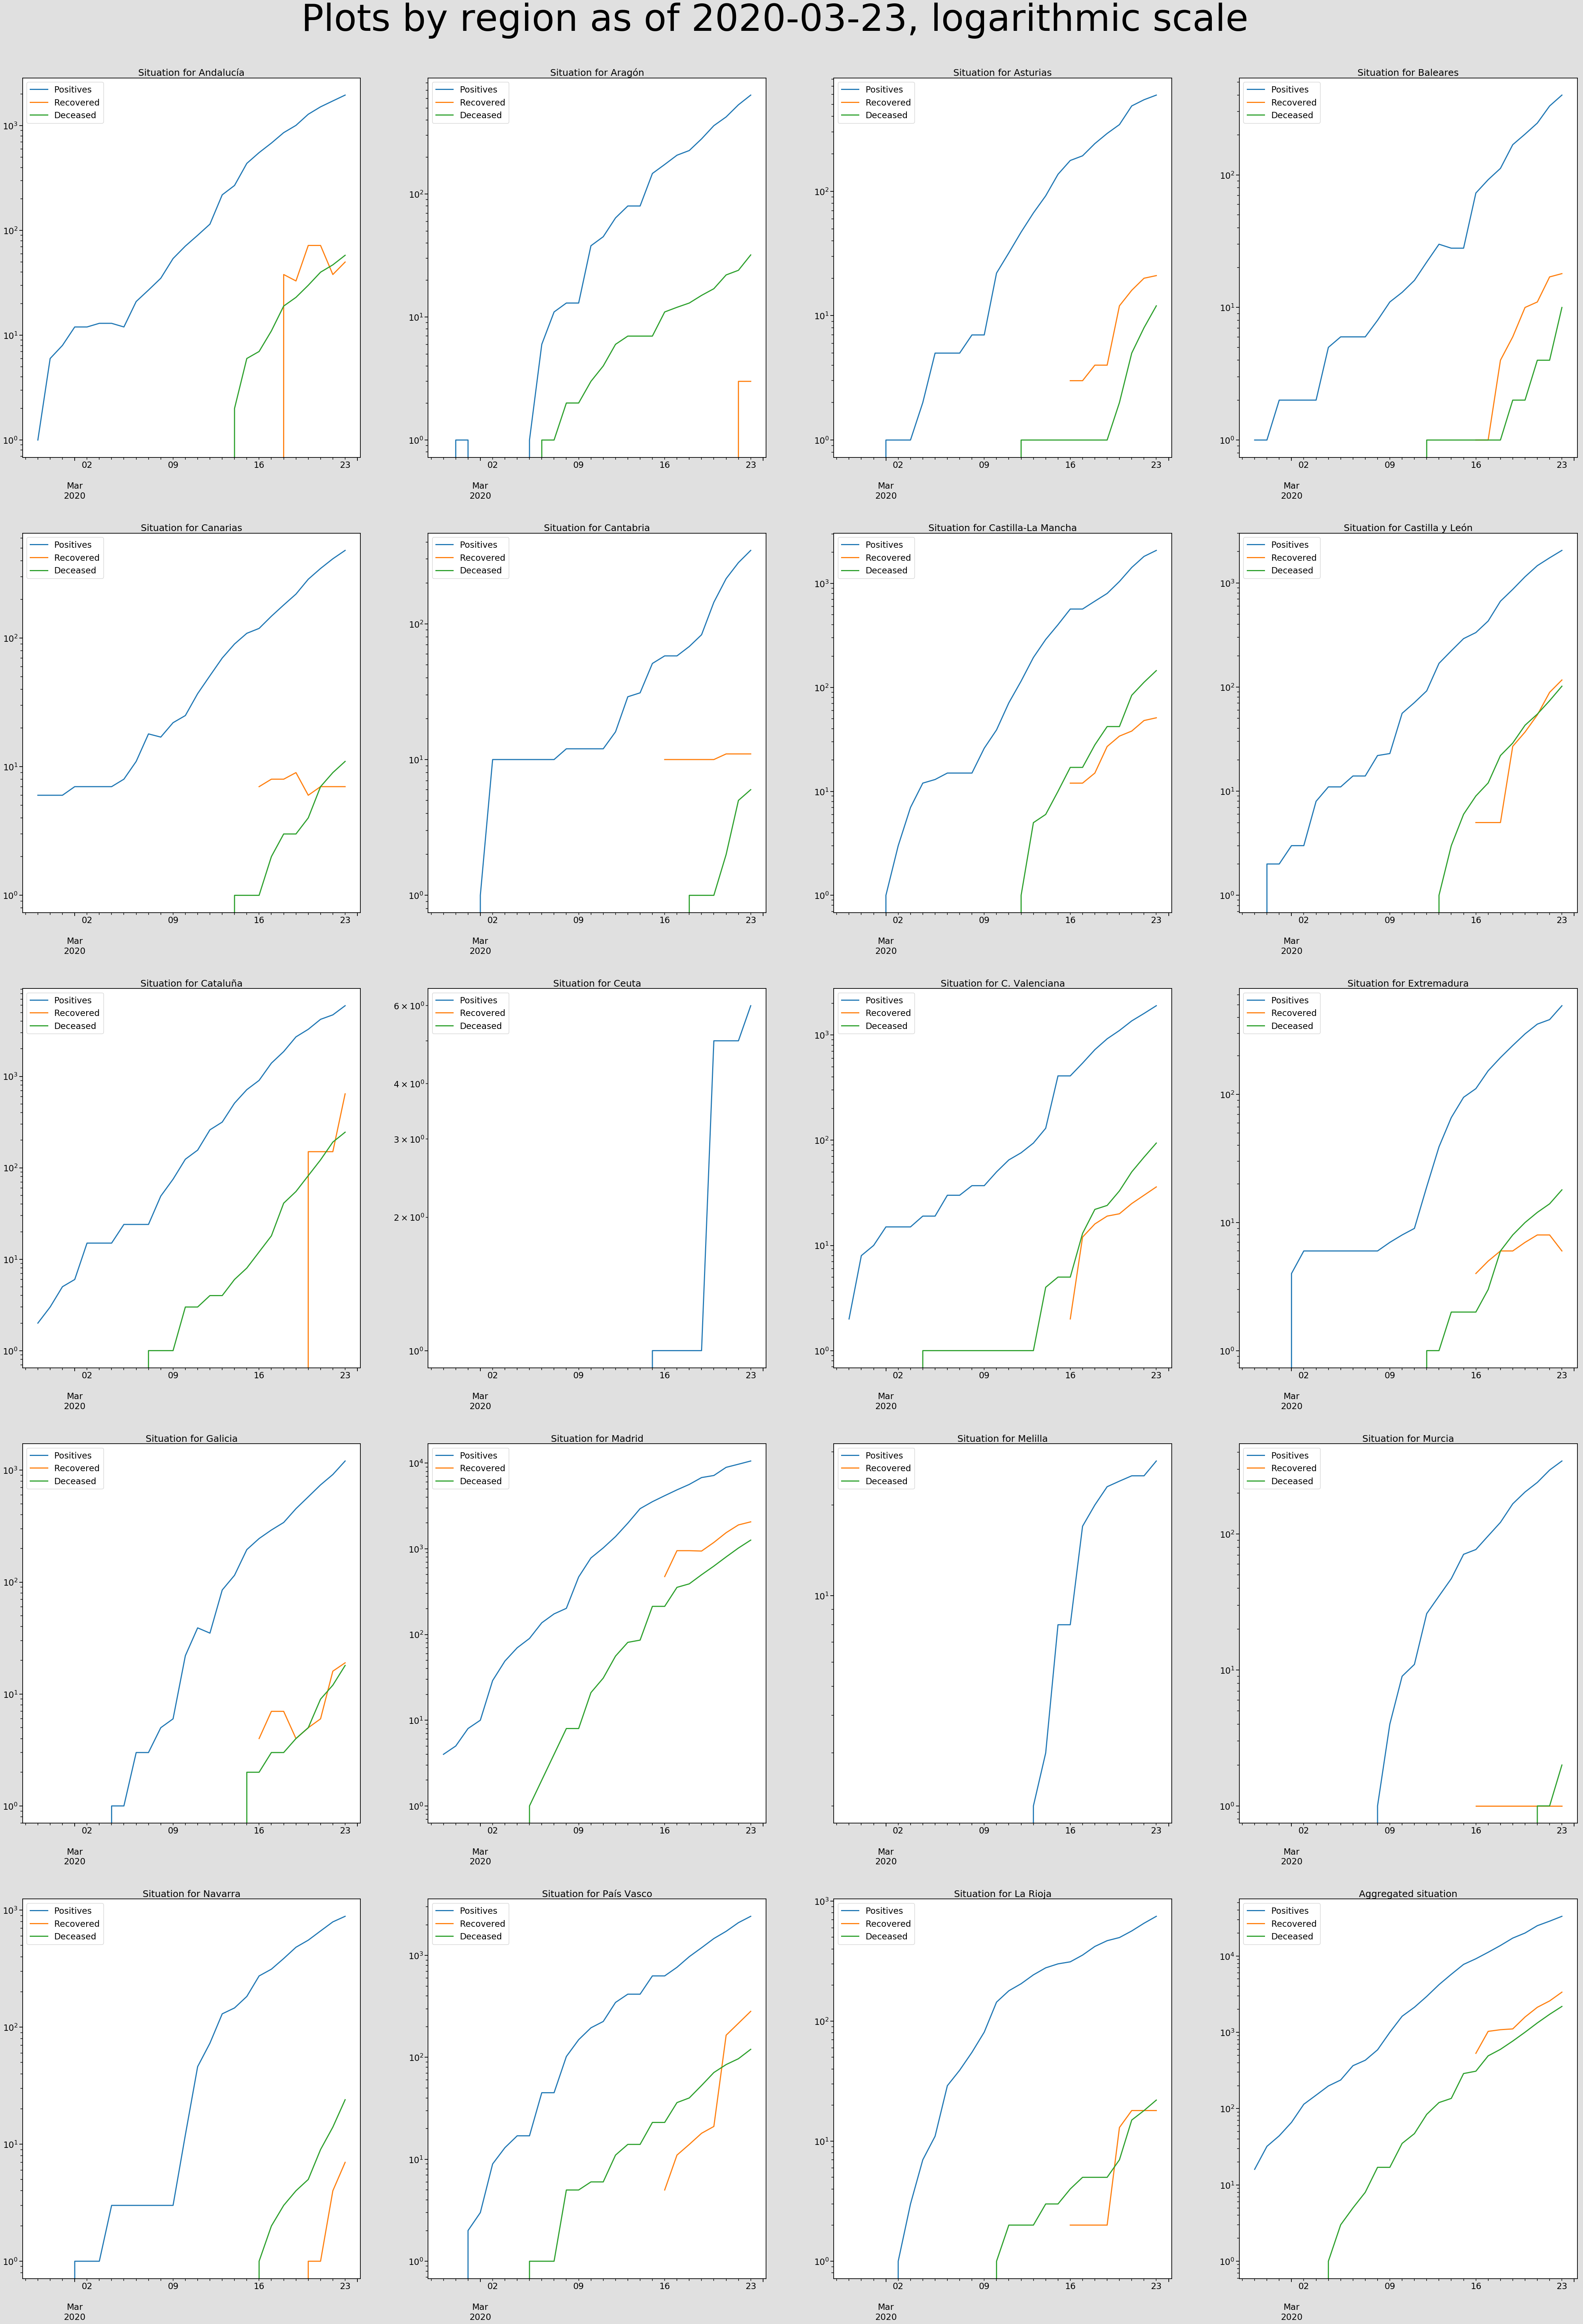

In [440]:
regional_plot(dfs, logscale=True)

**Growth rates, total and regional**

We obtain the percent growth rates for each dataset, measured daily. 100% growth rate means that the figure has doubled from the previous day.

In [442]:
rates = {}

for k, df_i in dfs.items():
    rates[k] = (((df_i / df_i.shift(1)).fillna(0)\
                                       .replace([np.inf, -np.inf], 1) - 1)\
                                       .clip(lower=0) * 100)

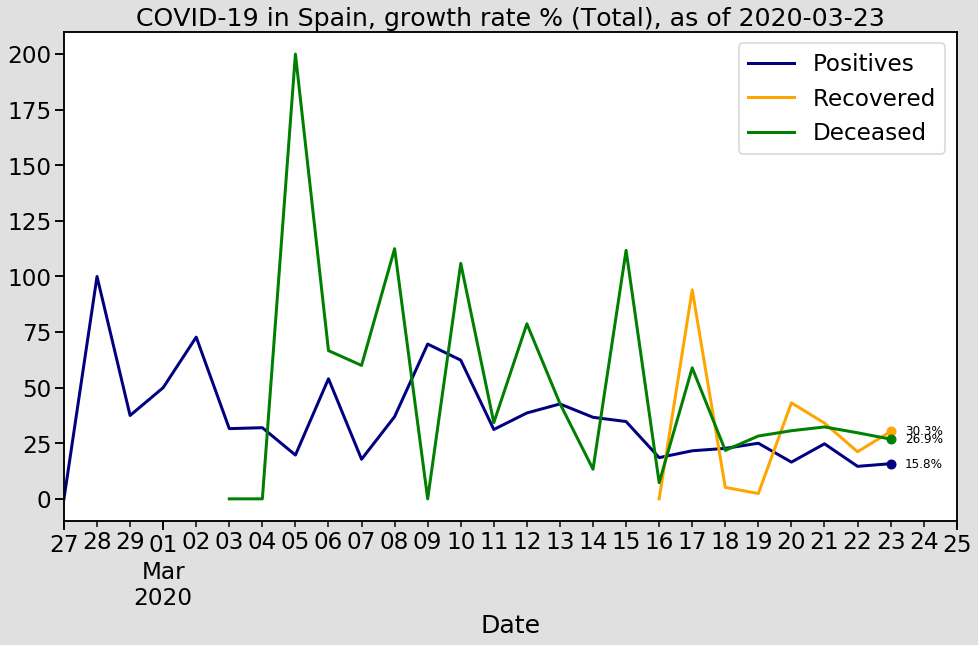

In [443]:
single_plot(rates, key_to_plot="Total", title="COVID-19 in Spain, growth rate %",
           plot_last=True, percent=True)

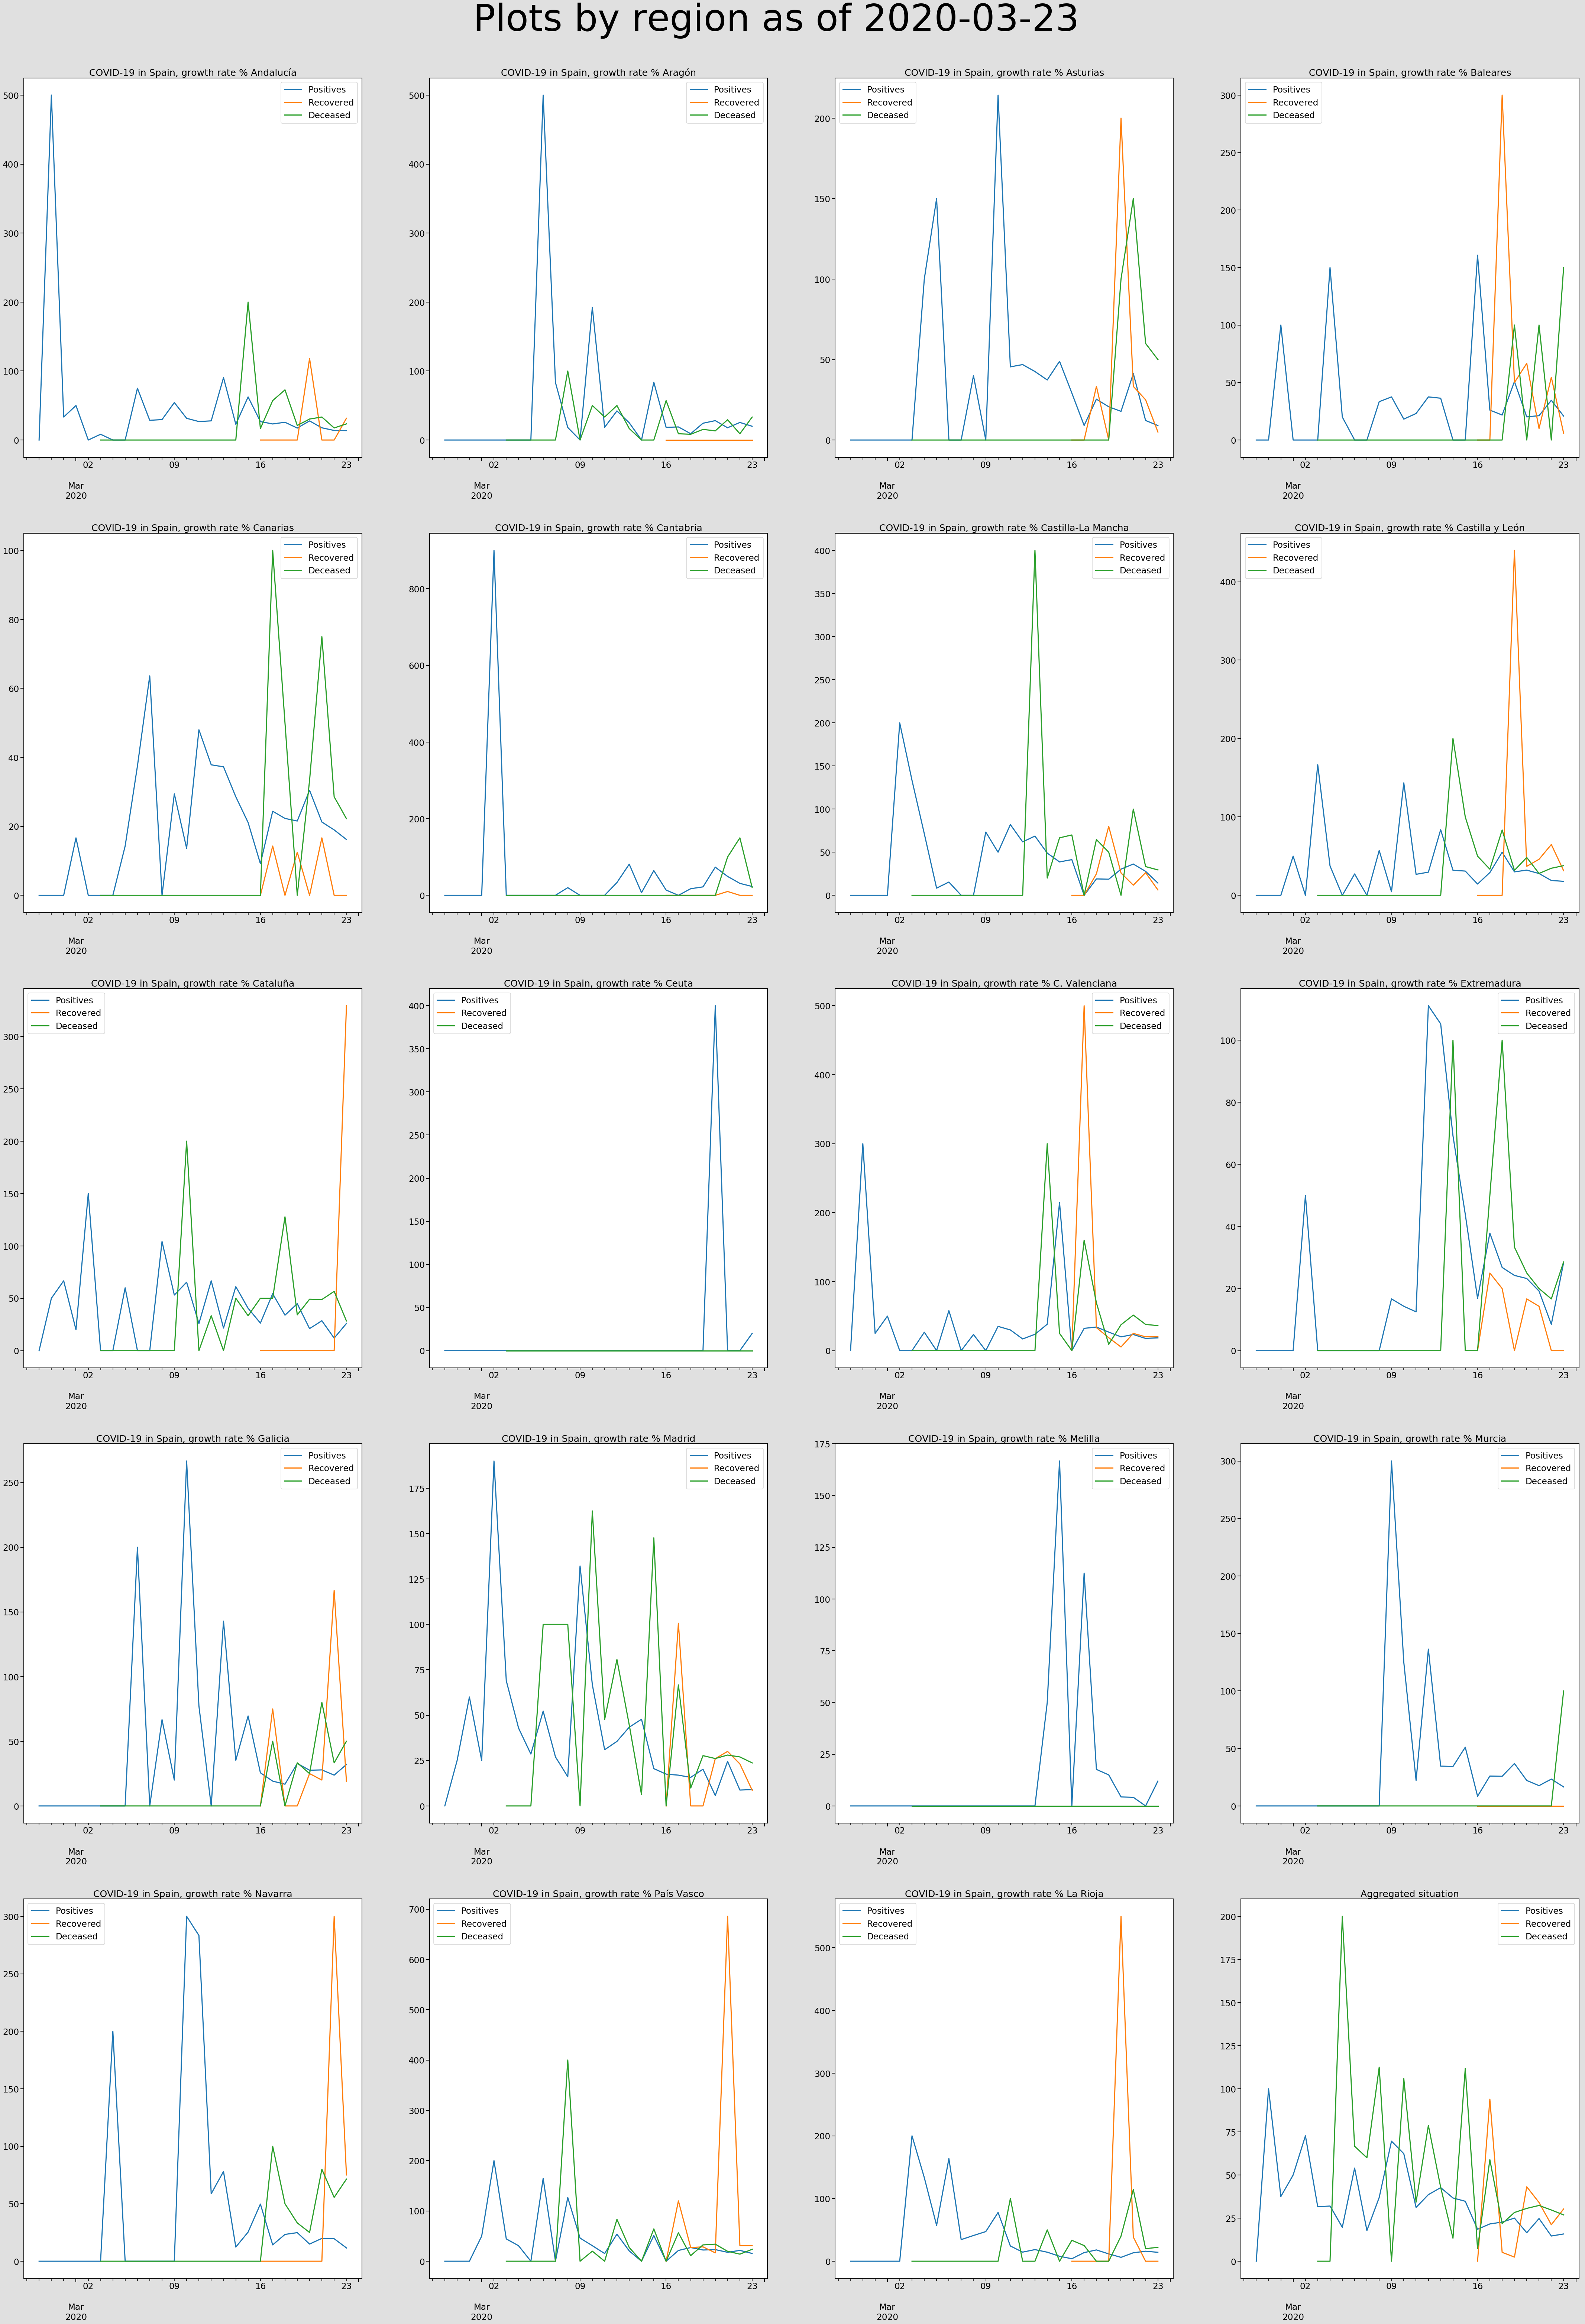

In [444]:
regional_plot(rates, title="COVID-19 in Spain, growth rate %")

Rates with smoothing

In [447]:
smoothed_rates = {}
NUM_DAYS_SMOOTH = 3

for k, df_i in rates.items():
    smoothed_rates[k] = df_i.rolling(window=NUM_DAYS_SMOOTH).mean()

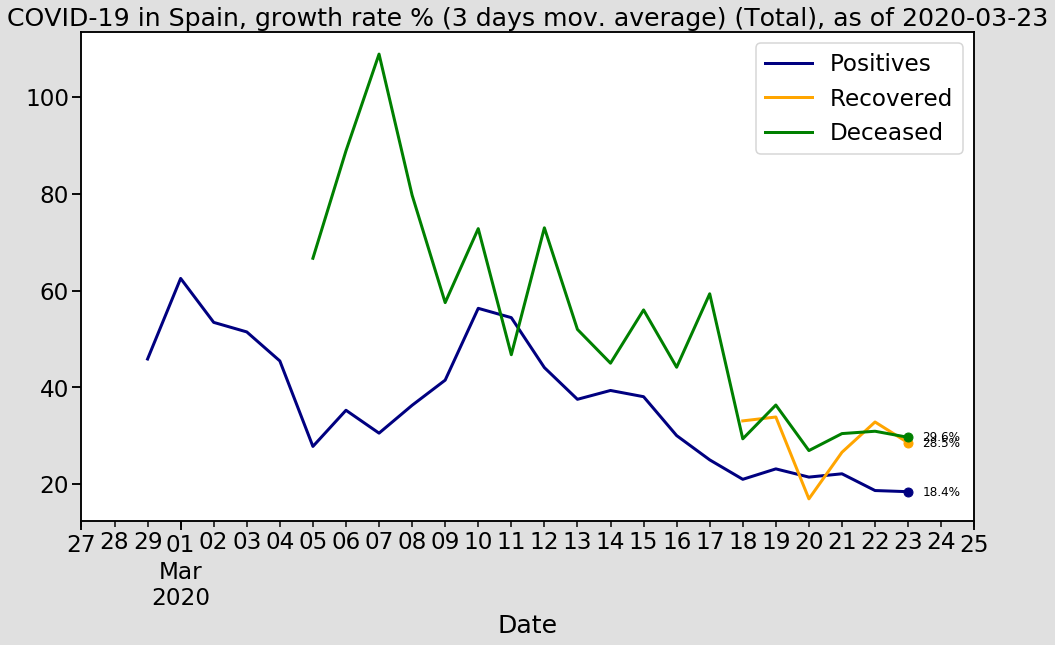

In [448]:
single_plot(smoothed_rates, key_to_plot="Total",
            title=f"COVID-19 in Spain, growth rate % ({NUM_DAYS_SMOOTH} days mov. average)",
            percent=True, plot_last=True)